# FIT5202 Assignment 2A : Building Models for Building Energy Prediction

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Hyperparameter Tuning and Model Optimisation](#part-3)  
Please add code/markdown cells as needed.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you must load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. For plotting, various visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and that the installation will be successful in the provided Docker container (in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
1.1.1 Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size does not exceed 32MB, and to run locally with all CPU cores on your machine

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment2A"
# Setup configuration parameters for Spark (16g/8g for 32 gb)
spark_conf = SparkConf().setMaster(master).setAppName(app_name) \
                        .set("spark.executor.memory", "4g") \
                        .set("spark.driver.memory", "2g") \
                        .set("spark.sql.files.maxPartitionBytes", "33554432")


# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')
from pyspark.sql import functions as F

1.1.2 Write code to define the schemas for the datasets, following the data types suggested in the metadata file. 

In [2]:
# Adapted from GPT
from pyspark.sql.types import (
    StructType, StructField,
    IntegerType, StringType, DecimalType, TimestampType
)

# 1. Meters Table
meters_schema = StructType([
    StructField("building_id", IntegerType(), False),
    StructField("meter_type", StringType(), False),   # Char(1) -> StringType
    StructField("ts", TimestampType(), False),
    StructField("value", DecimalType(15, 4), False),
    StructField("row_id", IntegerType(), False)
])

# 2. Buildings Table
buildings_schema = StructType([
    StructField("site_id", IntegerType(), False),
    StructField("building_id", IntegerType(), False),
    StructField("primary_use", StringType(), True),
    StructField("square_feet", IntegerType(), True),
    StructField("floor_count", IntegerType(), True),
    StructField("row_id", IntegerType(), False),
    StructField("year_built", IntegerType(), True),
    StructField("latent_y", DecimalType(6, 4), True),
    StructField("latent_s", DecimalType(6, 4), True),
    StructField("latent_r", DecimalType(6, 4), True)
])

# 3. Weather Table
weather_schema = StructType([
    StructField("site_id", IntegerType(), False),
    StructField("timestamp", TimestampType(), False),
    StructField("air_temperature", DecimalType(5, 3), True),
    StructField("cloud_coverage", DecimalType(5, 3), True), # Is an Integer, but ends with a ".0", so read as a DecimalType
    StructField("dew_temperature", DecimalType(5, 3), True),
    StructField("sea_level_pressure", DecimalType(8, 3), True),
    StructField("wind_direction", DecimalType(5, 3), True), # Is an Integer, but ends with a ".0", so read as a DecimalType
    StructField("wind_speed", DecimalType(5, 3), True)
])


1.1.3 Using your schemas, load the CSV files into separate data frames. Print the schemas of all data frames. 

In [3]:
# from GPT
meters_df = spark.read.csv(
    "data/meters.csv",
    header=True,
    schema=meters_schema
)

buildings_df = spark.read.csv(
    "data/building_information.csv",
    header=True,
    schema=buildings_schema
)

weather_df = spark.read.csv(
    "data/weather.csv",
    header=True,
    schema=weather_schema
)
print("Meters DF:")
meters_df.printSchema()
print("Buildings DF:")
buildings_df.printSchema()
print("Weather DF")
weather_df.printSchema()


Meters DF:
root
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- value: decimal(15,4) (nullable = true)
 |-- row_id: integer (nullable = true)

Buildings DF:
root
 |-- site_id: integer (nullable = true)
 |-- building_id: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: decimal(6,4) (nullable = true)
 |-- latent_s: decimal(6,4) (nullable = true)
 |-- latent_r: decimal(6,4) (nullable = true)

Weather DF
root
 |-- site_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- air_temperature: decimal(5,3) (nullable = true)
 |-- cloud_coverage: decimal(5,3) (nullable = true)
 |-- dew_temperature: decimal(5,3) (nullable = true)
 |-- sea_level_pressure: decimal(8,3) (nullable = true)
 |-- win

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In this section, we primarily have three tasks:  
1.2.1 The dataset includes sensors with hourly energy measurements. However, as a grid operator, we don’t need this level of granularity and lowering it can reduce the amount of data we need to process. For each building, we will aggregate the metered energy consumption in 6-hour intervals (0:00-5:59, 6:00-11:59, 12:00-17:59, 18:00-23:59). This will be our target (label) column for this prediction. Perform the aggregation for each building.


In [4]:
# Adapted from A1 and GPT
# Meters df
# Split timestamp to date and time bucket
meters_df = meters_df.withColumn("date", F.to_date("ts")).withColumn(
    "time",
    F.when(F.hour("ts") <= 5, "0-6h")
     .when(F.hour("ts") <= 11, "6-12h")
     .when(F.hour("ts") <= 17, "12-18h")
     .when(F.hour("ts") <= 23, "18-24h")
     .otherwise("unknown")   # catch any unexpected cases
)

# Aggregate by time bucket
meters_df = (
    meters_df.groupBy("building_id", "meter_type", "date", "time")
    .agg(F.sum("value").cast(DecimalType(15, 4)).alias("power_usage"))
)
meters_df.show(3)


+-----------+----------+----------+------+-----------+
|building_id|meter_type|      date|  time|power_usage|
+-----------+----------+----------+------+-----------+
|        244|         c|2022-01-01| 6-12h|    36.3642|
|       1214|         c|2022-01-01| 6-12h|   444.3222|
|       1259|         c|2022-01-01|12-18h|   385.0202|
+-----------+----------+----------+------+-----------+
only showing top 3 rows



In the weather dataset, there are some missing values (null or empty strings). It may lower the quality of our model. Imputation is a way to deal with those missing values. Imputation is the process of replacing missing values in a dataset with substituted, or "imputed," values. It's a way to handle gaps in your data so that you can still analyse it effectively without having to delete incomplete records.  
1.2.2 Refer to the Spark MLLib imputation API and fill in the missing values in the weather dataset. You can use mean values as the strategy.  https://spark.apache.org/docs/3.5.5/api/python/reference/api/pyspark.ml.feature.Imputer.html

In [5]:
# from GPT
# Weather df
# Split timestamp to date, month, time bucket
weather_df = weather_df.withColumn("date", F.to_date("timestamp")).withColumn(
    "time",
    F.when(F.hour("timestamp") <= 5, "0-6h")
     .when(F.hour("timestamp") <= 11, "6-12h")
     .when(F.hour("timestamp") <= 17, "12-18h")
     .when(F.hour("timestamp") <= 23, "18-24h")
).withColumn("month", F.month("timestamp"))

# Choose which columns to impute
impute_cols = [
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "sea_level_pressure",
    "wind_direction",
    "wind_speed"
]

# Global means once
global_means = weather_df.select(
    *[F.mean(c).alias(c) for c in impute_cols]
).first().asDict()

# Step 1: site_id + month
site_month_means = weather_df.groupBy("site_id", "month").agg(
    *[F.mean(c).alias(f"{c}_site_month_mean") for c in impute_cols]
)
weather_df = weather_df.join(site_month_means, on=["site_id", "month"], how="left")
for c in impute_cols:
    weather_df = weather_df.withColumn(
        c, F.coalesce(c, F.col(f"{c}_site_month_mean"))
    ).drop(f"{c}_site_month_mean")

# Garbage collection
weather_df = weather_df.unpersist()

# Step 2: site_id
site_means = weather_df.groupBy("site_id").agg(
    *[F.mean(c).alias(f"{c}_site_mean") for c in impute_cols]
)
weather_df = weather_df.join(site_means, on="site_id", how="left")
for c in impute_cols:
    weather_df = weather_df.withColumn(
        c, F.coalesce(c, F.col(f"{c}_site_mean"))
    ).drop(f"{c}_site_mean")

# Step 3: global fallback
for c in impute_cols:
    weather_df = weather_df.withColumn(
        c, F.coalesce(c, F.lit(global_means[c]))
    )
    
# Garbage collection
del site_month_means
del site_means
del global_means
spark.catalog.clearCache()
    
# Aggregate by time bucket
weather_df = (
    weather_df.groupBy("site_id", "date", "time", "month")
    .agg(
        F.mean("air_temperature").cast(DecimalType(5, 3)).alias("air_temperature"),
        F.mean("cloud_coverage").cast(DecimalType(5, 3)).alias("cloud_coverage"),
        F.mean("dew_temperature").cast(DecimalType(5, 3)).alias("dew_temperature"),
        F.mean("sea_level_pressure").cast(DecimalType(8, 3)).alias("sea_level_pressure"),
        F.mean("wind_direction").cast(DecimalType(5, 3)).alias("wind_direction"),
        F.mean("wind_speed").cast(DecimalType(5, 3)).alias("wind_speed"),        
    )
)

weather_df.show(5)


+-------+----------+------+-----+---------------+--------------+---------------+------------------+--------------+----------+
|site_id|      date|  time|month|air_temperature|cloud_coverage|dew_temperature|sea_level_pressure|wind_direction|wind_speed|
+-------+----------+------+-----+---------------+--------------+---------------+------------------+--------------+----------+
|      1|2022-01-01|  0-6h|    1|          2.800|         0.000|          1.950|          1022.067|        49.722|     1.617|
|      1|2022-01-01| 6-12h|    1|          3.117|         0.000|          1.683|          1021.850|        73.222|     2.300|
|      1|2022-01-01|12-18h|    1|          7.450|         0.000|          5.450|          1015.683|        59.667|     5.917|
|      1|2022-01-01|18-24h|    1|          8.183|         0.000|          6.433|          1008.167|        59.667|     8.050|
|      1|2022-01-02|  0-6h|    1|          8.800|         0.000|          8.017|          1001.400|        59.667|    

We know that different seasons may affect energy consumption—for instance, a heater in winter and a cooler in summer. Extracting peak seasons (summer and winter) or off-peak seasons (Spring and Autumn) might be more useful than directly using the month as numerical values.   
1.2.3 The dataset has 16 sites in total, whose locations may span across different countries. Add a column (peak/off-peak) to the weather data frame based on the average air temperature. The top 3 hottest months and the 3 coldest months are considered “peak”, and the rest of the year is considered “off-peak”. 

In [6]:
from pyspark.sql.window import Window
# adapted from A1, tuned with GPT
# Group median temp per site/month
monthly_temp = (
    weather_df
    .groupBy("site_id", "month")
    .agg(F.expr("percentile_approx(air_temperature, 0.5)").alias("median_temp"))
)

# Define windows
w_asc = Window.partitionBy("site_id").orderBy(F.col("median_temp").asc())
w_desc = Window.partitionBy("site_id").orderBy(F.col("median_temp").desc())

# Rank + add peak/offpeak column in one step, drop ranks immediately
monthly_temp_ranked = (
    monthly_temp
    .withColumn("rank_cold", F.row_number().over(w_asc))
    .withColumn("rank_hot", F.row_number().over(w_desc))
    .withColumn(
        "peak_offpeak",
        F.when((F.col("rank_cold") <= 3) | (F.col("rank_hot") <= 3), "peak")
         .otherwise("off-peak")
    )
    .select("site_id", "month", "median_temp", "peak_offpeak")    
)

# Join back
weather_df = weather_df.join(monthly_temp_ranked, ["site_id","month"], "left")

weather_df.show(3)
del monthly_temp_ranked

+-------+-----+----------+------+---------------+--------------+---------------+------------------+--------------+----------+-----------+------------+
|site_id|month|      date|  time|air_temperature|cloud_coverage|dew_temperature|sea_level_pressure|wind_direction|wind_speed|median_temp|peak_offpeak|
+-------+-----+----------+------+---------------+--------------+---------------+------------------+--------------+----------+-----------+------------+
|      1|    1|2022-01-01|  0-6h|          2.800|         0.000|          1.950|          1022.067|        49.722|     1.617|      6.417|        peak|
|      1|    1|2022-01-01| 6-12h|          3.117|         0.000|          1.683|          1021.850|        73.222|     2.300|      6.417|        peak|
|      1|    1|2022-01-01|12-18h|          7.450|         0.000|          5.450|          1015.683|        59.667|     5.917|      6.417|        peak|
+-------+-----+----------+------+---------------+--------------+---------------+--------------

Create a data frame with all relevant columns at this stage, we refer to this data frame as feature_df.

In [7]:
# Meters -> Join with Buildings (building_id)
meters_buildings = meters_df.join(buildings_df, ["building_id"], "left")
# Meters + Buildings -> Join with Weather (site_id, date, time)
feature_df = meters_buildings.join(weather_df, ["site_id", "date", "time"])
feature_df.show(3)

+-------+----------+------+-----------+----------+-----------+-----------+-----------+-----------+------+----------+--------+--------+--------+-----+---------------+--------------+---------------+------------------+--------------+----------+-----------+------------+
|site_id|      date|  time|building_id|meter_type|power_usage|primary_use|square_feet|floor_count|row_id|year_built|latent_y|latent_s|latent_r|month|air_temperature|cloud_coverage|dew_temperature|sea_level_pressure|wind_direction|wind_speed|median_temp|peak_offpeak|
+-------+----------+------+-----------+----------+-----------+-----------+-----------+-----------+------+----------+--------+--------+--------+-----+---------------+--------------+---------------+------------------+--------------+----------+-----------+------------+
|      2|2022-01-05|12-18h|        180|         c|   346.7614|  Education|      24586|          1|   181|      2002|  2.0000|  4.3907|  3.0000|    1|         11.300|         3.120|          9.233|   

In [8]:
meters_buildings.printSchema()
weather_df.printSchema()

root
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = false)
 |-- power_usage: decimal(15,4) (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: decimal(6,4) (nullable = true)
 |-- latent_s: decimal(6,4) (nullable = true)
 |-- latent_r: decimal(6,4) (nullable = true)

root
 |-- site_id: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- air_temperature: decimal(5,3) (nullable = true)
 |-- cloud_coverage: decimal(5,3) (nullable = true)
 |-- dew_temperature: decimal(5,3) (nullable = true)
 |-- sea_level_pressure: decimal(8,3) (nullable = true)
 |-- wind_direction: decimal(

In [9]:
# Meters DF:
# root
#  |-- building_id: integer (nullable = true)
#  |-- meter_type: string (nullable = true)
#  |-- ts: timestamp (nullable = true)
#  |-- value: decimal(10,4) (nullable = true)
#  |-- row_id: integer (nullable = true)

# Buildings DF:
# root
#  |-- site_id: integer (nullable = true)
#  |-- building_id: integer (nullable = true)
#  |-- primary_use: string (nullable = true)
#  |-- square_feet: integer (nullable = true)
#  |-- floor_count: integer (nullable = true)
#  |-- row_id: integer (nullable = true)
#  |-- year_built: integer (nullable = true)
#  |-- latent_y: decimal(10,4) (nullable = true)
#  |-- latent_s: decimal(10,4) (nullable = true)
#  |-- latent_r: decimal(10,4) (nullable = true)

# Weather DF
# root
#  |-- site_id: integer (nullable = true)
#  |-- timestamp: timestamp (nullable = true)
#  |-- air_temperature: decimal(6,2) (nullable = true)
#  |-- cloud_coverage: decimal(6,2) (nullable = true)
#  |-- dew_temperature: decimal(6,2) (nullable = true)
#  |-- sea_level_pressure: decimal(8,2) (nullable = true)
#  |-- wind_direction: decimal(6,2) (nullable = true)
#  |-- wind_speed: decimal(6,2) (nullable = true)

# Extra columns: month, median_temp, peak_offpeak
print("Feature df: ")
feature_df.printSchema()

Feature df: 
root
 |-- site_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = false)
 |-- building_id: integer (nullable = true)
 |-- meter_type: string (nullable = true)
 |-- power_usage: decimal(15,4) (nullable = true)
 |-- primary_use: string (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- floor_count: integer (nullable = true)
 |-- row_id: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- latent_y: decimal(6,4) (nullable = true)
 |-- latent_s: decimal(6,4) (nullable = true)
 |-- latent_r: decimal(6,4) (nullable = true)
 |-- month: integer (nullable = true)
 |-- air_temperature: decimal(5,3) (nullable = true)
 |-- cloud_coverage: decimal(5,3) (nullable = true)
 |-- dew_temperature: decimal(5,3) (nullable = true)
 |-- sea_level_pressure: decimal(8,3) (nullable = true)
 |-- wind_direction: decimal(5,3) (nullable = true)
 |-- wind_speed: decimal(5,3) (nullable = true)
 |-- median_temp: decimal(5,3) (

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
You can use either the CDA or the EDA method mentioned in Lab 5.  
Some ideas for CDA:  
a)	Older building may not be as efficient as new ones, therefore need more energy for cooling/heating. It’s not necessarily true though, if the buildings are built with higher standard or renovated later.  
b)	A multifloored or larger building obviously consumes more energy.  

1.	With the feature_df, write code to show the basic statistics:  
a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile;  
b) For each non-numeric column, display the top-5 values and the corresponding counts;  
c) For each boolean column, display the value and count. (note: pandas describe is allowed for this task.) (5%)

In [10]:
# ### IT WORKS, but I'm commenting it out so I don't recompute this on "run all"

# # Get columns grouped by type
# numeric_cols = [f.name for f in feature_df.schema.fields if f.dataType.simpleString().startswith(("int", "double", "float", "decimal", "long", "short"))]
# string_cols  = [f.name for f in feature_df.schema.fields if f.dataType.simpleString().startswith("string")]
# boolean_cols = [f.name for f in feature_df.schema.fields if f.dataType.simpleString().startswith("boolean")]

# # === A) Numeric columns stats ===
# for col in numeric_cols:
#     # Base aggregations
#     stats = feature_df.select(
#         F.count(F.col(col)).alias("count"),
#         F.mean(F.col(col)).cast(DecimalType(15, 4)).alias("mean"),
#         F.stddev(F.col(col)).cast(DecimalType(15, 4)).alias("stddev"),
#         F.min(F.col(col)).alias("min"),
#         F.max(F.col(col)).cast(DecimalType(15, 4)).alias("max"),
#     ).collect()[0].asDict()

#     # Add quantiles
#     quantiles = feature_df.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
#     stats.update({"25%": quantiles[0], "50%": quantiles[1], "75%": quantiles[2]})

#     # Convert to DataFrame for nice display
#     df_stats = feature_df.sparkSession.createDataFrame([stats])
#     print(f"--- Stats for numeric column: {col} ---")
#     df_stats.show(truncate=False)

# # === B) Non-numeric (string) columns top-5 values ===
# for col in string_cols:
#     print(f"--- Top 5 values for string column: {col} ---")
#     feature_df.groupBy(col).count().orderBy(F.desc("count")).show(5)

# # === C) Boolean columns counts ===
# for col in boolean_cols:
#     print(f"--- Value counts for boolean column: {col} ---")
#     feature_df.groupBy(col).count().show()



In [11]:

# print("Meters DF:")
# meters_df.printSchema()
# print("Buildings DF:")
# buildings_df.printSchema()
# print("Weather DF")
# weather_df.printSchema()
# print("Feature DF")
# feature_df.printSchema()

2.	Explore the dataframe and write code to present two plots of multivariate analysis, describe your plots and discuss the findings from the plots. (5% each).  
○	150 words max for each plot’s description and discussion.  
○	Note: In the building metadata table, there are some latent columns (data that may or may not be helpful, their meanings is unknown due to privacy and data security concerns).  
○	Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc. You can refer to https://samplecode.link  


In [12]:
# Based on the linear regression evaluation, it looks that the two most important factors in power usage are the 
# usage purpose of the building, and the location/country/region of the building (or whatever site_id represents).


SyntaxError: invalid syntax (1770046115.py, line 1)


=== Building model evaluation ===
R²   : 0.4056
RMSE : 1.3685

=== Weather model evaluation ===
R²   : 0.1964
RMSE : 1.5912


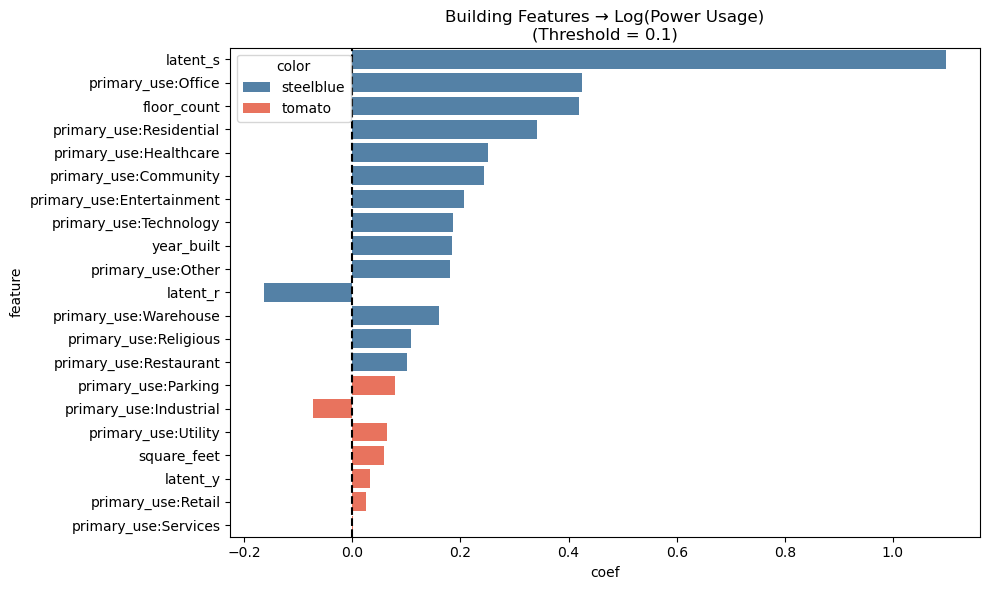

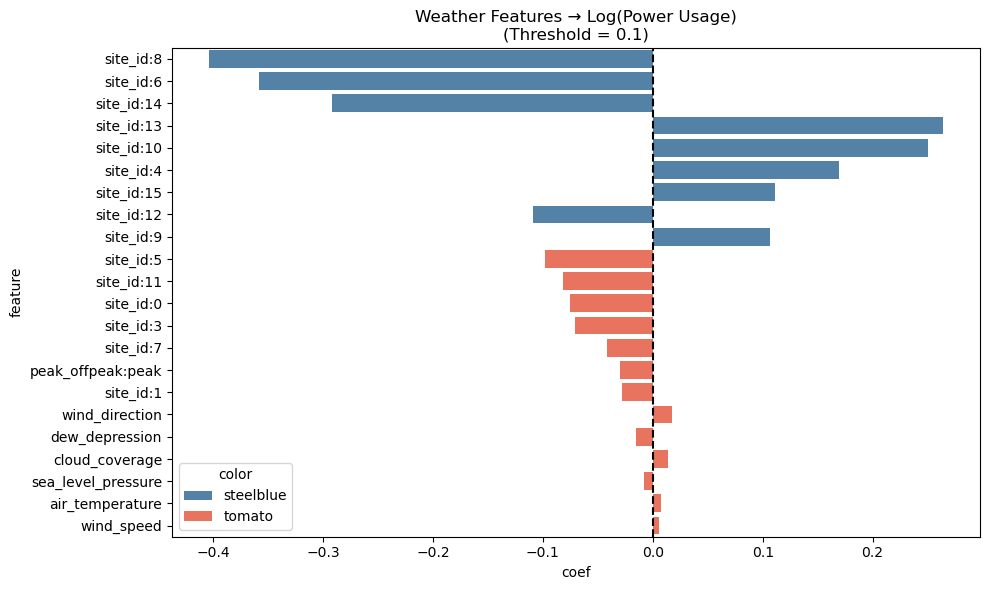

In [22]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1) Prepare dataframe: filter + transform
# ------------------------------------------------------------
df = (
    feature_df
    .withColumn("power_usage", F.col("power_usage").cast("double"))
    .withColumn("square_feet", F.col("square_feet").cast("double"))
    .withColumn("floor_count", F.col("floor_count").cast("double"))
    .withColumn("year_built", F.col("year_built").cast("double"))
    .withColumn("latent_y", F.col("latent_y").cast("double"))
    .withColumn("latent_s", F.col("latent_s").cast("double"))
    .withColumn("latent_r", F.col("latent_r").cast("double"))
    .withColumn("air_temperature", F.col("air_temperature").cast("double"))
    .withColumn("cloud_coverage", F.col("cloud_coverage").cast("double"))
#     .withColumn("dew_temperature", F.col("dew_temperature").cast("double"))
    .withColumn("sea_level_pressure", F.col("sea_level_pressure").cast("double"))
    .withColumn("wind_direction", F.col("wind_direction").cast("double"))
    .withColumn("wind_speed", F.col("wind_speed").cast("double"))
    .withColumn("dew_depression",(F.col("air_temperature") - F.col("dew_temperature").cast("double")))
#     .withColumn("median_temp", F.col("median_temp").cast("double"))
    .dropna(subset=[
        "power_usage","square_feet","floor_count","year_built",
        "latent_y","latent_s","latent_r",
        "air_temperature","cloud_coverage","sea_level_pressure",
        "wind_direction","wind_speed","dew_depression",
        "primary_use","peak_offpeak"
    ])
)

# Keep only what we need
df = df.select(
    "power_usage","primary_use","square_feet","floor_count","year_built",
    "latent_y","latent_s","latent_r",
    "air_temperature","cloud_coverage","sea_level_pressure",
    "wind_direction","wind_speed","dew_depression","peak_offpeak", "site_id"
)

# Log-transform target (power_usage)
# df = df.sample(False, 0.2, 42)
df = df.withColumn("log_power_usage", F.log1p(F.col("power_usage")))

# Materialize sample before IQR filter
df = df.cache()
df.count()

# IQR filtering (efficient, only on log_power_usage now)
def iqr_filter(df, colname):
    q1, q3 = df.approxQuantile(colname, [0.25, 0.75], 0.01)  # tighter relErr
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df.filter((F.col(colname) >= lower) & (F.col(colname) <= upper))

df = iqr_filter(df, "log_power_usage").cache()
df.count()  # cut down rows early

# ------------------------------------------------------------
# 2) Define pipelines
# ------------------------------------------------------------

# Building-related features
building_indexer = StringIndexer(
    inputCol="primary_use", outputCol="primary_use_index", handleInvalid="skip"
)
building_encoder = OneHotEncoder(
    inputCols=["primary_use_index"], outputCols=["primary_use_ohe"]
)

building_features = [
    "square_feet", "floor_count", "year_built",
    "latent_y", "latent_s", "latent_r", "primary_use_ohe"
]
building_assembler = VectorAssembler(
    inputCols=building_features, outputCol="raw_features", handleInvalid="skip"
)
building_scaler = StandardScaler(
    inputCol="raw_features", outputCol="features", withMean=True, withStd=True
)


lr_building = LinearRegression(
    featuresCol="features", labelCol="log_power_usage", maxIter=20
)

pipeline_building = Pipeline(
    stages=[building_indexer, building_encoder, building_assembler, building_scaler, lr_building]
)


# Weather-related features
site_indexer = StringIndexer(
    inputCol="site_id", outputCol="site_id_index", handleInvalid="skip"
)
site_encoder = OneHotEncoder(
    inputCols=["site_id_index"], outputCols=["site_id_ohe"]
)

weather_indexer = StringIndexer(
    inputCol="peak_offpeak", outputCol="peak_offpeak_index", handleInvalid="skip"
)
weather_encoder = OneHotEncoder(
    inputCols=["peak_offpeak_index"], outputCols=["peak_offpeak_ohe"]
)

weather_features = [
    "air_temperature", "cloud_coverage", "sea_level_pressure",
    "wind_direction","wind_speed", "dew_depression", "peak_offpeak_ohe", "site_id_ohe"
]
weather_assembler = VectorAssembler(
    inputCols=weather_features, outputCol="raw_features", handleInvalid="skip"
)
weather_scaler = StandardScaler(
    inputCol="raw_features", outputCol="features", withMean=True, withStd=True
)

lr_weather = LinearRegression(
    featuresCol="features", labelCol="log_power_usage", maxIter=20
)

pipeline_weather = Pipeline(
    stages=[weather_indexer, weather_encoder, site_indexer, site_encoder, weather_assembler, weather_scaler, lr_weather]
)

# ------------------------------------------------------------
# 3) Train/test split and fit models
# ------------------------------------------------------------
train, test = df.randomSplit([0.7, 0.3], seed=42)

building_model = pipeline_building.fit(train)
building_lr_model = building_model.stages[-1]

weather_model = pipeline_weather.fit(train)
weather_lr_model = weather_model.stages[-1]

# ------------------------------------------------------------
# 4) Coefficients extraction helper
# ------------------------------------------------------------
def extract_coefs(pipeline_model, lr_model, indexer_stage, ohe_prefix, base_features):
    indexer_model = pipeline_model.stages[indexer_stage]
    labels = indexer_model.labels
    ohe_features = [f"{ohe_prefix}:{lbl}" for lbl in labels[1:]]  # drop first
    feature_names = base_features + ohe_features
    coefs = lr_model.coefficients.toArray()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    return coef_df.reindex(coef_df["coef"].abs().sort_values(ascending=False).index)

def extract_coefs_multiple(pipeline_model, lr_model, indexer_stages, ohe_prefixes, base_features):
    feature_names = base_features.copy()
    
    for stage_idx, prefix in zip(indexer_stages, ohe_prefixes):
        indexer_model = pipeline_model.stages[stage_idx]
        labels = indexer_model.labels
        ohe_features = [f"{prefix}:{lbl}" for lbl in labels[1:]]  # drop first dummy
        feature_names += ohe_features
    
    coefs = lr_model.coefficients.toArray()
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    return coef_df.reindex(coef_df["coef"].abs().sort_values(ascending=False).index)

# Building coefficients
building_base = ["square_feet", "floor_count", "year_built", "latent_y", "latent_s", "latent_r"]
building_coef_df = extract_coefs(building_model, building_lr_model, 0, "primary_use", building_base)

# Weather coefficients
weather_base = ["air_temperature", "cloud_coverage", "sea_level_pressure",
                "wind_direction","wind_speed", "dew_depression"]
weather_coef_df = extract_coefs_multiple(
    weather_model, weather_lr_model,
    indexer_stages=[0, 2],        # 0 = peak_offpeak indexer, 2 = site_id indexer
    ohe_prefixes=["peak_offpeak", "site_id"],
    base_features=weather_base
)
# ------------------------------------------------------------
# 5) Evaluate on test set
# ------------------------------------------------------------
evaluator_r2 = RegressionEvaluator(labelCol="log_power_usage", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="log_power_usage", predictionCol="prediction", metricName="rmse")

preds_building = building_model.transform(test).cache()
r2_building = evaluator_r2.evaluate(preds_building)
rmse_building = evaluator_rmse.evaluate(preds_building)

preds_weather = weather_model.transform(test).cache()
r2_weather = evaluator_r2.evaluate(preds_weather)
rmse_weather = evaluator_rmse.evaluate(preds_weather)

print("\n=== Building model evaluation ===")
print(f"R²   : {r2_building:.4f}")
print(f"RMSE : {rmse_building:.4f}")

print("\n=== Weather model evaluation ===")
print(f"R²   : {r2_weather:.4f}")
print(f"RMSE : {rmse_weather:.4f}")

# ------------------------------------------------------------
# 6) Plot (ordered, color-coded by coef magnitude)
# ------------------------------------------------------------
def plot_coefs(coef_df, title, threshold=0.1):
    # Color features by whether their absolute coef exceeds threshold
    coef_df = coef_df.copy()
    coef_df["color"] = coef_df["coef"].apply(
        lambda x: "steelblue" if abs(x) >= threshold else "tomato"
    )

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=coef_df,
        x="coef", y="feature",
        hue="color", dodge=False,
        palette={"tomato": "tomato", "steelblue": "steelblue"}
    )
    plt.axvline(0, color="black", linestyle="--")
    plt.title(f"{title}\n(Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

plot_coefs(building_coef_df, "Building Features → Log(Power Usage)")
plot_coefs(weather_coef_df, "Weather Features → Log(Power Usage)")


In [ ]:
# === Building model evaluation ===
# R²   : 0.4056
# RMSE : 1.3685

# === Weather model evaluation ===
# R²   : 0.1964
# RMSE : 1.5912
building_features = ["latent_s", "floor_count", "primary_use", "year_built", "latent_r"]
# dropped: square_feet, latent_y
weather_features = ["site_id"]
# dropped: dew_depression, sea_level_pressure, air_temperature, wind_speed, cloud_coverage, wind_direction

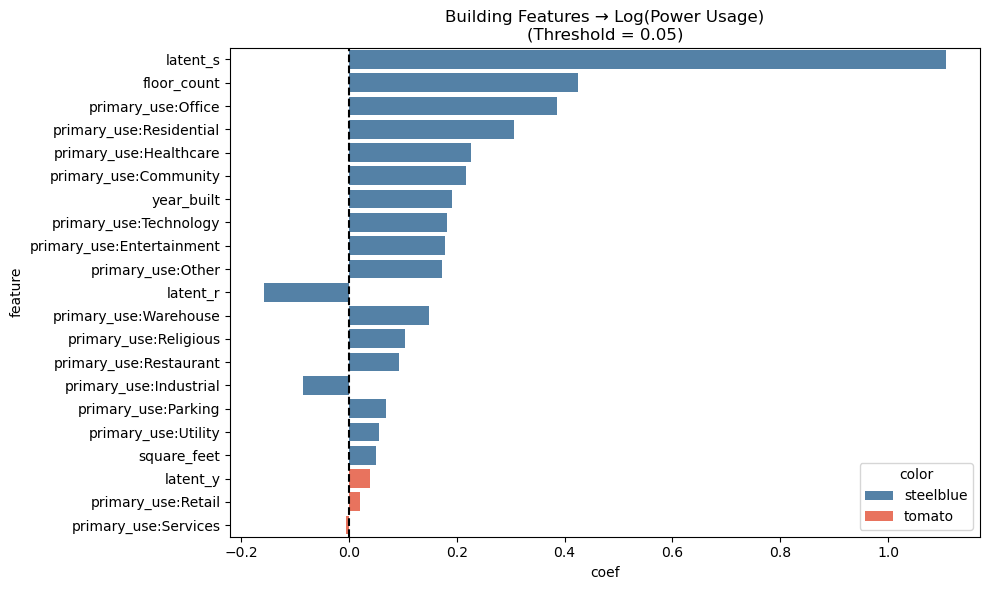

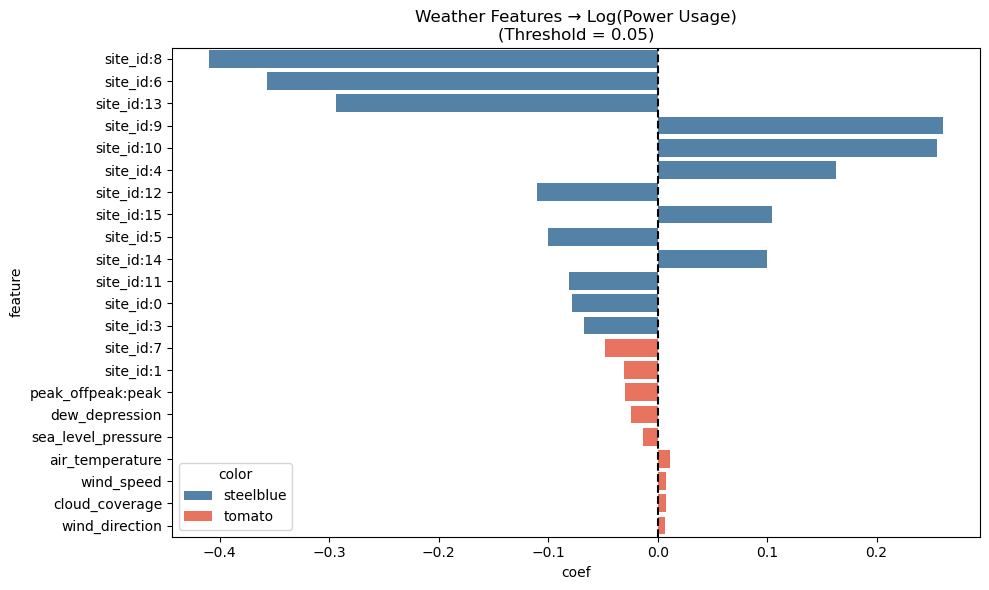

In [18]:
# def plot_coefs(coef_df, title, threshold=0.05):
#     # Color features by whether their absolute coef exceeds threshold
#     coef_df = coef_df.copy()
#     coef_df["color"] = coef_df["coef"].apply(
#         lambda x: "steelblue" if abs(x) >= threshold else "tomato"
#     )

#     plt.figure(figsize=(10,6))
#     sns.barplot(
#         data=coef_df,
#         x="coef", y="feature",
#         hue="color", dodge=False,
#         palette={"tomato": "tomato", "steelblue": "steelblue"}
#     )
#     plt.axvline(0, color="black", linestyle="--")
#     plt.title(f"{title}\n(Threshold = {threshold})")
#     plt.tight_layout()
#     plt.show()

# plot_coefs(building_coef_df, "Building Features → Log(Power Usage)")
# plot_coefs(weather_coef_df, "Weather Features → Log(Power Usage)")



In [ ]:
# def check_nulls_nans(df):
#     checks = []
#     for c, dtype in df.dtypes:
#         if dtype in ["double", "float", "decimal"]:  # check for NaN too
#             checks.append(
#                 F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c + "_invalid")
#             )
#         else:  # only null check
#             checks.append(
#                 F.count(F.when(F.col(c).isNull(), c)).alias(c + "_nulls")
#             )
#     return df.select(checks)

# # wind speed wind direction sea level pressure

# check_nulls_nans(df).show(truncate=False)

In [ ]:
# check_nulls_nans(meters_df).show(truncate=False)
# # check_nulls_nans(pre_meters_df).show(truncate=False)

# check_nulls_nans(weather_df).show(truncate=False)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Option 1: collect all (only if the dataset is not huge)
# # power_usage_pd = feature_df.select("power_usage").toPandas()

# # Option 2: sample 100k rows if dataset is very large
# power_usage_pd = feature_df.select("power_usage").sample(fraction=0.05, seed=42).toPandas()
# plt.figure(figsize=(8,5))
# sns.histplot(power_usage_pd["power_usage"], bins=100, kde=False)
# plt.xlabel("Power Usage")
# plt.ylabel("Count")
# plt.title("Distribution of power_usage")
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure all values are float
# power_usage_pd["power_usage"] = power_usage_pd["power_usage"].astype(float)

# # Log-scaled histogram
# plt.figure(figsize=(8,5))
# sns.histplot(np.log1p(power_usage_pd["power_usage"]), bins=100, kde=False)
# plt.xlabel("log(1 + power_usage)")
# plt.ylabel("Count")
# plt.title("Log-Scaled Distribution of power_usage")
# plt.show()


In [ ]:
# zero_count = (power_usage_pd["power_usage"] == 0).sum()
# total_count = len(power_usage_pd)
# print(f"Zeros: {zero_count} ({zero_count/total_count:.2%})")

# plt.figure(figsize=(8,5))
# sns.ecdfplot(power_usage_pd["power_usage"])
# plt.xlabel("Power Usage")
# plt.ylabel("ECDF")
# plt.title("Cumulative Distribution of power_usage")
# plt.show()


## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you must use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, should not be used to process the data; however, it’s fine to use them to display the result or evaluate your model.  
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the use case, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a significant impact on the label column, which should be transformed), which features you are planning to use? Discuss the reasons for selecting them and how you plan to create/transform them.  
○	300 words max for the discussion  
○	Please only use the provided data for model building  
○	You can create/add additional features based on the dataset  
○	Hint - Use the insights from the data exploration/domain knowledge/statistical models to consider whether to create more feature columns, whether to remove some columns  

In [ ]:
# building_features = ["latent_s", "floor_count", "primary_use", "year_built", "latent_r"]
# dropped: square_feet, latent_y
# weather_features = ["site_id"]
# dropped: dew_depression, sea_level_pressure, air_temperature, wind_speed, cloud_coverage, wind_direction

2.1.2 Write code to create/transform the columns based on your discussion above.

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1 and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet.**

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor

def build_ml_pipeline(
    categorical_cols,
    numeric_cols,
    label_col="power_usage",
    model_type="rf"
):
    """
    Build a Spark ML pipeline for Random Forest or Gradient-Boosted Trees.

    Parameters
    ----------
    categorical_cols : list of str
        List of categorical feature column names.
    numeric_cols : list of str
        List of numeric feature column names.
    label_col : str
        Target column.
    model_type : str
        'rf' for RandomForest, 'gbt' for Gradient-Boosted Tree.

    Returns
    -------
    pipeline : pyspark.ml.Pipeline
        Configured pipeline ready to fit().
    """

    stages = []

    # --- Handle categorical features ---
    indexers = [
        StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
        for col in categorical_cols
    ]

    encoders = [
        OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe")
        for col in categorical_cols
    ]

    stages += indexers + encoders

    # --- Numeric features ---
    # Convert decimals to double if necessary
    casted_numeric = [
        F.col(col).cast("double").alias(col) for col in numeric_cols + [label_col]
    ]

    # Vector Assembler
    feature_cols = [f"{c}_ohe" for c in categorical_cols] + numeric_cols
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    stages.append(assembler)

    # (Optional) Feature scaling (trees don’t need it, but handy if you swap in other models)
    # scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    # stages.append(scaler)

    # --- Model ---
    if model_type == "rf":
        estimator = RandomForestRegressor(
            featuresCol="features", labelCol=label_col, predictionCol="prediction"
        )
    elif model_type == "gbt":
        estimator = GBTRegressor(
            featuresCol="features", labelCol=label_col, predictionCol="prediction"
        )
    else:
        raise ValueError("model_type must be 'rf' or 'gbt'")

    stages.append(estimator)

    pipeline = Pipeline(stages=stages)
    return pipeline


**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet.**

In [ ]:
categorical_cols = ["meter_type", "primary_use", "peak_offpeak", "site_id"]
numeric_cols = [
    "square_feet", "floor_count", "year_built", "latent_y", "latent_s", "latent_r",
    "month", "air_temperature", "cloud_coverage", "dew_temperature",
    "sea_level_pressure", "wind_direction", "wind_speed", "median_temp"
]

# Random Forest pipeline
rf_pipeline = build_ml_pipeline(categorical_cols, numeric_cols, model_type="rf")

# GBT pipeline
gbt_pipeline = build_ml_pipeline(categorical_cols, numeric_cols, model_type="gbt")

# Fit
rf_model = rf_pipeline.fit(feature_df)
gbt_model = gbt_pipeline.fit(feature_df)


### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing, using 2025 as the random seed. You can decide the train/test split ratio based on the resources available on your laptop.  
Note: Due to the large dataset size, you can use random sampling (say 20% of the dataset). 

### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

2.4.2 For both models (RF and GBT): with the test data, decide on which metrics to use for model evaluation and discuss which one is the better model (no word limit; please keep it concise). You may also use a plot for visualisation (not mandatory).

2.4.3 3.	Save the better model (you’ll need it for A2B).
(Note: You may need to go through a few training loops or use more data to create a better-performing model.)

### Part 3. Hyperparameter Tuning and Model Optimisation <a class="anchor" name="part-3"></a>  
Apply the techniques you have learnt from the labs, for example, CrossValidator, TrainValidationSplit, ParamGridBuilder, etc., to perform further hyperparameter tuning and model optimisation.  
The assessment is based on the quality of your work/process, not the quality of your model. Please include your thoughts/ideas/discussions.

## References:
Please add your references below: